# Model training #1

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.ensemble import RandomForestClassifier

# tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import AlphaDropout, Conv1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
tf.test.is_gpu_available(cuda_only=True)

True

### Data transformation/split:

In [3]:
featuretype = pd.read_csv('feature_types_final.csv', sep=';')
df = pd.read_csv('data_clean_onehot_final_withnans.csv', sep=';')

# preprocess
df = df.sample(frac=1) # shuffle the data beforehand
dataset = df.dropna().values

# test and validation ratio
test_step = .1

# features and output
X = dataset[:,0:-1]
Y = dataset[:,-1]

# indexing
test_index = int(X.shape[0]*(1-test_step))

# test split
X_test = X[test_index:]
Y_test = Y[test_index:]
# Y_test = to_categorical(Y[test_index:],2)

# training split
X_train = X[:test_index]
Y_train = Y[:test_index]
# Y_train = to_categorical(Y[:test_index],2)


# MinMax scaling

scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)
y_train = Y_train.astype(int)
y_test = Y_test.astype(int)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4713, 46)
(4713,)
(524, 46)
(524,)


### Build the tf.keras.Sequential model by stacking layers.

Defaults are based on the hyper-parameter optimization.


In [15]:
def create_model(in_dim, dense_layer_sizes = 24, dropout_ratios = .4, depth = 7,
                 kernin = 'glorot_uniform', opti = 'adam', activ= 'selu'):
    
    model = Sequential()
    model.add(Dense(dense_layer_sizes,
                    activation=activ,
                    kernel_initializer=kernin,
                    input_shape=(in_dim,)))
    
#     note: for testing Conv1D as first layer (ditched since no visible improvement)
#     model.add(Conv1D(6, (6), activation=activ, input_shape=(32,1)))
#     model.add(Flatten())

    for i in range(depth-1): 
        model.add(Dropout(dropout_ratios))
        # model.add(BatchNormalization())
        # model.add(AlphaDropout(dropout_ratios))
        model.add(Dense(dense_layer_sizes,
                        activation=activ,
                        kernel_initializer=kernin))
        
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer=kernin)) # softmax if the output is shaped as 2-dim
    
    model.compile(optimizer=opti,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


Cross-validation training with callbacks:

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=40, verbose=1)
redlrplat = tf.keras.callbacks.ReduceLROnPlateau(patience=20, verbose=1)
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model1.hdf5', save_best_only=True, verbose=1)


# note: for testing Conv1D as first layer (ditched since no visible improvement)
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1],1)

skf = StratifiedKFold(n_splits=10, shuffle=True)

cross_histories = []
for train_index, valid_index in skf.split(x_train, y_train):
    model = create_model(in_dim = x_train.shape[1])
    
    # Train and evaluate model:
    network_history=model.fit(x_train[train_index], y_train[train_index], 
                batch_size=16, 
                epochs=150, 
                verbose=1,
                shuffle=True,
                validation_data=(x_train[valid_index], y_train[valid_index]), 
                callbacks=[early_stopping, redlrplat])
    cross_histories.append(network_history)

Train on 4241 samples, validate on 472 samples
Epoch 1/150
4241/4241 [==============================] - 3s 671us/sample - loss: 0.7778 - acc: 0.5117 - val_loss: 0.6917 - val_acc: 0.5297
Epoch 2/150
4241/4241 [==============================] - 1s 332us/sample - loss: 0.7111 - acc: 0.5060 - val_loss: 0.6940 - val_acc: 0.5169
Epoch 3/150
4241/4241 [==============================] - 1s 340us/sample - loss: 0.7069 - acc: 0.5086 - val_loss: 0.6816 - val_acc: 0.5742
Epoch 4/150
4241/4241 [==============================] - 1s 344us/sample - loss: 0.7042 - acc: 0.5086 - val_loss: 0.6853 - val_acc: 0.5847
Epoch 5/150
4241/4241 [==============================] - 2s 354us/sample - loss: 0.7043 - acc: 0.5039 - val_loss: 0.6823 - val_acc: 0.5593
Epoch 6/150
4241/4241 [==============================] - 1s 336us/sample - loss: 0.6935 - acc: 0.5279 - val_loss: 0.6752 - val_acc: 0.5742
Epoch 7/150
4241/4241 [==============================] - 2s 362us/sample - loss: 0.6927 - acc: 0.5492 - val_loss: 0.666

Epoch 13/150
4241/4241 [==============================] - 1s 351us/sample - loss: 0.6450 - acc: 0.6357 - val_loss: 0.6496 - val_acc: 0.6398
Epoch 14/150
4241/4241 [==============================] - 2s 375us/sample - loss: 0.6465 - acc: 0.6399 - val_loss: 0.6335 - val_acc: 0.6483
Epoch 15/150
4241/4241 [==============================] - 2s 389us/sample - loss: 0.6368 - acc: 0.6494 - val_loss: 0.6330 - val_acc: 0.6525
Epoch 16/150
4241/4241 [==============================] - 1s 353us/sample - loss: 0.6370 - acc: 0.6557 - val_loss: 0.6283 - val_acc: 0.6758
Epoch 17/150
4241/4241 [==============================] - 2s 374us/sample - loss: 0.6347 - acc: 0.6557 - val_loss: 0.6428 - val_acc: 0.6462
Epoch 18/150
4241/4241 [==============================] - 2s 380us/sample - loss: 0.6328 - acc: 0.6602 - val_loss: 0.6399 - val_acc: 0.6398
Epoch 19/150
4241/4241 [==============================] - 2s 370us/sample - loss: 0.6370 - acc: 0.6638 - val_loss: 0.6364 - val_acc: 0.6547
Epoch 20/150
4241/42

Epoch 36/150
4241/4241 [==============================] - 1s 333us/sample - loss: 0.6159 - acc: 0.6748 - val_loss: 0.5926 - val_acc: 0.6907
Epoch 37/150
4241/4241 [==============================] - 1s 337us/sample - loss: 0.6203 - acc: 0.6770 - val_loss: 0.5916 - val_acc: 0.6822
Epoch 38/150
4241/4241 [==============================] - 1s 336us/sample - loss: 0.6172 - acc: 0.6765 - val_loss: 0.5947 - val_acc: 0.6992
Epoch 39/150
4241/4241 [==============================] - 1s 336us/sample - loss: 0.6161 - acc: 0.6760 - val_loss: 0.5923 - val_acc: 0.6907
Epoch 40/150
4241/4241 [==============================] - 1s 334us/sample - loss: 0.6158 - acc: 0.6739 - val_loss: 0.5920 - val_acc: 0.7013
Epoch 41/150
4241/4241 [==============================] - 1s 339us/sample - loss: 0.6162 - acc: 0.6755 - val_loss: 0.5893 - val_acc: 0.6801
Epoch 42/150
4241/4241 [==============================] - 1s 354us/sample - loss: 0.6163 - acc: 0.6831 - val_loss: 0.5902 - val_acc: 0.6992
Epoch 43/150
4241/42

4241/4241 [==============================] - 1s 325us/sample - loss: 0.6289 - acc: 0.6734 - val_loss: 0.6170 - val_acc: 0.6758
Epoch 23/150
4241/4241 [==============================] - 1s 331us/sample - loss: 0.6268 - acc: 0.6697 - val_loss: 0.6203 - val_acc: 0.6631
Epoch 24/150
4241/4241 [==============================] - 2s 369us/sample - loss: 0.6248 - acc: 0.6708 - val_loss: 0.6150 - val_acc: 0.6758
Epoch 25/150
4241/4241 [==============================] - 2s 369us/sample - loss: 0.6219 - acc: 0.6781 - val_loss: 0.6103 - val_acc: 0.6907
Epoch 26/150
4241/4241 [==============================] - 1s 345us/sample - loss: 0.6253 - acc: 0.6682 - val_loss: 0.6170 - val_acc: 0.6780
Epoch 27/150
4241/4241 [==============================] - 1s 337us/sample - loss: 0.6226 - acc: 0.6751 - val_loss: 0.6118 - val_acc: 0.6822
Epoch 28/150
4241/4241 [==============================] - 1s 336us/sample - loss: 0.6239 - acc: 0.6727 - val_loss: 0.6160 - val_acc: 0.6801
Epoch 29/150
4241/4241 [=========

4241/4241 [==============================] - 3s 817us/sample - loss: 0.8066 - acc: 0.4945 - val_loss: 0.6949 - val_acc: 0.5064
Epoch 2/150
4241/4241 [==============================] - 1s 346us/sample - loss: 0.7171 - acc: 0.5197 - val_loss: 0.6890 - val_acc: 0.5191
Epoch 3/150
4241/4241 [==============================] - 1s 348us/sample - loss: 0.7092 - acc: 0.5081 - val_loss: 0.6957 - val_acc: 0.4661
Epoch 4/150
4241/4241 [==============================] - 2s 383us/sample - loss: 0.7060 - acc: 0.5065 - val_loss: 0.6986 - val_acc: 0.4958
Epoch 5/150
4241/4241 [==============================] - 1s 345us/sample - loss: 0.7027 - acc: 0.4999 - val_loss: 0.6876 - val_acc: 0.5572
Epoch 6/150
4241/4241 [==============================] - 1s 346us/sample - loss: 0.7029 - acc: 0.5098 - val_loss: 0.6800 - val_acc: 0.5720
Epoch 7/150
4241/4241 [==============================] - 2s 390us/sample - loss: 0.6904 - acc: 0.5371 - val_loss: 0.6568 - val_acc: 0.6186
Epoch 8/150
4241/4241 [================

Epoch 26/150
4242/4242 [==============================] - 2s 394us/sample - loss: 0.6214 - acc: 0.6744 - val_loss: 0.5928 - val_acc: 0.7197
Epoch 27/150
4242/4242 [==============================] - 1s 334us/sample - loss: 0.6240 - acc: 0.6711 - val_loss: 0.5935 - val_acc: 0.7049
Epoch 28/150
4242/4242 [==============================] - 1s 328us/sample - loss: 0.6249 - acc: 0.6777 - val_loss: 0.6025 - val_acc: 0.7049
Epoch 29/150
4242/4242 [==============================] - 2s 391us/sample - loss: 0.6231 - acc: 0.6716 - val_loss: 0.5912 - val_acc: 0.7028
Epoch 30/150
4242/4242 [==============================] - 1s 331us/sample - loss: 0.6260 - acc: 0.6742 - val_loss: 0.5933 - val_acc: 0.6921
Epoch 31/150
4242/4242 [==============================] - 1s 349us/sample - loss: 0.6262 - acc: 0.6709 - val_loss: 0.5909 - val_acc: 0.7091
Epoch 32/150
4242/4242 [==============================] - 1s 343us/sample - loss: 0.6203 - acc: 0.6792 - val_loss: 0.5969 - val_acc: 0.7070
Epoch 33/150
4242/42

Epoch 30/150
4242/4242 [==============================] - 2s 362us/sample - loss: 0.6166 - acc: 0.6822 - val_loss: 0.5872 - val_acc: 0.6985
Epoch 31/150
4242/4242 [==============================] - 1s 353us/sample - loss: 0.6195 - acc: 0.6794 - val_loss: 0.5882 - val_acc: 0.7113
Epoch 32/150
4242/4242 [==============================] - 2s 363us/sample - loss: 0.6215 - acc: 0.6740 - val_loss: 0.5898 - val_acc: 0.6985
Epoch 33/150
4242/4242 [==============================] - 2s 374us/sample - loss: 0.6142 - acc: 0.6867 - val_loss: 0.5855 - val_acc: 0.7028
Epoch 34/150
4242/4242 [==============================] - 2s 366us/sample - loss: 0.6182 - acc: 0.6789 - val_loss: 0.5901 - val_acc: 0.7006
Epoch 35/150
4242/4242 [==============================] - 2s 359us/sample - loss: 0.6146 - acc: 0.6806 - val_loss: 0.5827 - val_acc: 0.7113
Epoch 36/150
4242/4242 [==============================] - 2s 369us/sample - loss: 0.6171 - acc: 0.6785 - val_loss: 0.5854 - val_acc: 0.6964
Epoch 37/150
4242/42

4242/4242 [==============================] - 2s 388us/sample - loss: 0.5983 - acc: 0.6902 - val_loss: 0.5756 - val_acc: 0.7091
Epoch 145/150
4242/4242 [==============================] - 2s 409us/sample - loss: 0.6013 - acc: 0.6905 - val_loss: 0.5756 - val_acc: 0.7113
Epoch 146/150
4242/4242 [==============================] - 2s 439us/sample - loss: 0.6014 - acc: 0.6874 - val_loss: 0.5757 - val_acc: 0.7091
Epoch 147/150
4242/4242 [==============================] - 2s 426us/sample - loss: 0.5966 - acc: 0.6924 - val_loss: 0.5756 - val_acc: 0.7091
Epoch 148/150
4242/4242 [==============================] - 2s 392us/sample - loss: 0.6012 - acc: 0.6926 - val_loss: 0.5757 - val_acc: 0.7070
Epoch 149/150
4242/4242 [==============================] - 2s 402us/sample - loss: 0.6001 - acc: 0.6933 - val_loss: 0.5757 - val_acc: 0.7091
Epoch 150/150
4242/4242 [==============================] - 2s 431us/sample - loss: 0.6003 - acc: 0.6935 - val_loss: 0.5756 - val_acc: 0.7091
Train on 4242 samples, vali

4242/4242 [==============================] - 2s 469us/sample - loss: 0.5894 - acc: 0.6917 - val_loss: 0.6121 - val_acc: 0.6645
Epoch 110/150
4242/4242 [==============================] - 3s 605us/sample - loss: 0.5886 - acc: 0.7008 - val_loss: 0.6125 - val_acc: 0.6624
Epoch 111/150
4242/4242 [==============================] - 2s 524us/sample - loss: 0.5877 - acc: 0.6947 - val_loss: 0.6113 - val_acc: 0.6730
Epoch 112/150
4242/4242 [==============================] - 2s 524us/sample - loss: 0.5905 - acc: 0.6987 - val_loss: 0.6128 - val_acc: 0.6582
Epoch 113/150
4224/4242 [============================>.] - ETA: 0s - loss: 0.5916 - acc: 0.6970
Epoch 00113: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
4242/4242 [==============================] - 2s 529us/sample - loss: 0.5914 - acc: 0.6973 - val_loss: 0.6115 - val_acc: 0.6752
Epoch 00113: early stopping
Train on 4243 samples, validate on 470 samples
Epoch 1/150
4243/4243 [==============================] - 5s 1ms/sample 

Epoch 53/150
4243/4243 [==============================] - 2s 420us/sample - loss: 0.6115 - acc: 0.6795 - val_loss: 0.5973 - val_acc: 0.7064
Epoch 54/150
4243/4243 [==============================] - 2s 475us/sample - loss: 0.6093 - acc: 0.6799 - val_loss: 0.5979 - val_acc: 0.7064
Epoch 55/150
4243/4243 [==============================] - 2s 482us/sample - loss: 0.6059 - acc: 0.6858 - val_loss: 0.5924 - val_acc: 0.7064
Epoch 56/150
4243/4243 [==============================] - 2s 458us/sample - loss: 0.6087 - acc: 0.6715 - val_loss: 0.6007 - val_acc: 0.6809
Epoch 57/150
4243/4243 [==============================] - 2s 490us/sample - loss: 0.6032 - acc: 0.6849 - val_loss: 0.5986 - val_acc: 0.7085
Epoch 58/150
4243/4243 [==============================] - 2s 564us/sample - loss: 0.6033 - acc: 0.6802 - val_loss: 0.6004 - val_acc: 0.7085
Epoch 59/150
4243/4243 [==============================] - 2s 521us/sample - loss: 0.6062 - acc: 0.6741 - val_loss: 0.5992 - val_acc: 0.7043
Epoch 60/150
4243/42

Epoch 14/150
4243/4243 [==============================] - 2s 455us/sample - loss: 0.6453 - acc: 0.6465 - val_loss: 0.6304 - val_acc: 0.6468
Epoch 15/150
4243/4243 [==============================] - 2s 466us/sample - loss: 0.6458 - acc: 0.6425 - val_loss: 0.6415 - val_acc: 0.6340
Epoch 16/150
4243/4243 [==============================] - 2s 419us/sample - loss: 0.6364 - acc: 0.6571 - val_loss: 0.6313 - val_acc: 0.6532
Epoch 17/150
4243/4243 [==============================] - 2s 415us/sample - loss: 0.6350 - acc: 0.6543 - val_loss: 0.6278 - val_acc: 0.6596
Epoch 18/150
4243/4243 [==============================] - 2s 380us/sample - loss: 0.6326 - acc: 0.6594 - val_loss: 0.6244 - val_acc: 0.6511
Epoch 19/150
4243/4243 [==============================] - 2s 380us/sample - loss: 0.6397 - acc: 0.6568 - val_loss: 0.6231 - val_acc: 0.6660
Epoch 20/150
4243/4243 [==============================] - 2s 374us/sample - loss: 0.6281 - acc: 0.6646 - val_loss: 0.6239 - val_acc: 0.6553
Epoch 21/150
4243/42

In [42]:
# print("Evaluation")
# model.evaluate(x_test, Y_test)

def plot_history(network_histories, fp=None):
    plt.figure(figsize=(20,4))
    plt.subplot(2,2,1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for network_history in network_histories:
        plt.plot(network_history.history['loss'])
    plt.legend(['Training'])

    plt.subplot(2,2,2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    for network_history in network_histories:
        plt.plot(network_history.history['acc'])
    plt.legend(['Training'], loc='lower right')

    plt.subplot(2,2,3)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for network_history in network_histories:
        plt.plot(network_history.history['val_loss'])
    plt.legend(['Validation'])

    plt.subplot(2,2,4)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    for network_history in network_histories:
        plt.plot(network_history.history['val_acc'])
    plt.legend(['Validation'], loc='lower right')
    
    plt.savefig(fp, bbox_inches='tight')
    plt.show()

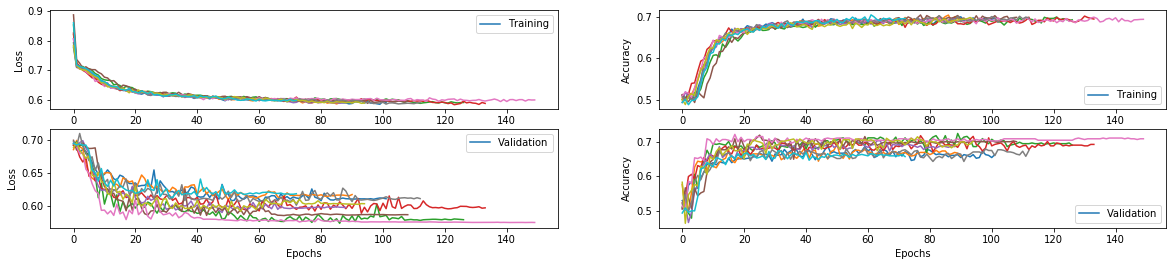

In [43]:
plot_history(cross_histories, 'model1_cross.pdf')

In [54]:
hhh= [ h.history for h in cross_histories ]
pickle.dump( hhh, open( "cv_histories_1.p", "wb" ) )

## Alternative network structure

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=40, verbose=1)
redlrplat = tf.keras.callbacks.ReduceLROnPlateau(patience=20, verbose=1)
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model1.hdf5', save_best_only=True, verbose=1)


# note: for testing Conv1D as first layer (ditched since no visible improvement)
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1],1)

skf = StratifiedKFold(n_splits=10, shuffle=True)

cross_histories2 = []
for train_index, valid_index in skf.split(x_train, y_train):
    model2 = create_model(in_dim = x_train.shape[1],
                         dense_layer_sizes = 40, dropout_ratios = .4, depth = 6,
                      kernin = 'glorot_normal', opti = 'rmsprop', activ= 'relu')
    
    # Train and evaluate model:
    network_history2=model2.fit(x_train[train_index], y_train[train_index], 
                batch_size=16, 
                epochs=150, 
                verbose=1,
                shuffle=True,
                validation_data=(x_train[valid_index], y_train[valid_index]), 
                callbacks=[early_stopping, redlrplat])
    cross_histories2.append(network_history2)

Train on 4241 samples, validate on 472 samples
Epoch 1/150
4241/4241 [==============================] - 5s 1ms/sample - loss: 0.6968 - acc: 0.4916 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 2/150
4241/4241 [==============================] - 2s 392us/sample - loss: 0.6915 - acc: 0.5256 - val_loss: 0.6891 - val_acc: 0.5530
Epoch 3/150
4241/4241 [==============================] - 2s 393us/sample - loss: 0.6797 - acc: 0.5796 - val_loss: 0.6758 - val_acc: 0.5847
Epoch 4/150
4241/4241 [==============================] - 2s 391us/sample - loss: 0.6685 - acc: 0.6098 - val_loss: 0.6538 - val_acc: 0.6462
Epoch 5/150
4241/4241 [==============================] - 2s 401us/sample - loss: 0.6548 - acc: 0.6348 - val_loss: 0.6472 - val_acc: 0.6568
Epoch 6/150
4241/4241 [==============================] - 2s 392us/sample - loss: 0.6447 - acc: 0.6444 - val_loss: 0.6521 - val_acc: 0.6356
Epoch 7/150
4241/4241 [==============================] - 2s 393us/sample - loss: 0.6352 - acc: 0.6508 - val_loss: 0.6496 

Epoch 53/150
4241/4241 [==============================] - 2s 421us/sample - loss: 0.6118 - acc: 0.6791 - val_loss: 0.6030 - val_acc: 0.7013
Epoch 54/150
4241/4241 [==============================] - 2s 423us/sample - loss: 0.6093 - acc: 0.6923 - val_loss: 0.5996 - val_acc: 0.6949
Epoch 55/150
4241/4241 [==============================] - 2s 424us/sample - loss: 0.6183 - acc: 0.6826 - val_loss: 0.5994 - val_acc: 0.6992
Epoch 56/150
4241/4241 [==============================] - 2s 413us/sample - loss: 0.6130 - acc: 0.6869 - val_loss: 0.5971 - val_acc: 0.6928
Epoch 57/150
4241/4241 [==============================] - 2s 410us/sample - loss: 0.6144 - acc: 0.6852 - val_loss: 0.6017 - val_acc: 0.6970
Epoch 58/150
4241/4241 [==============================] - 2s 411us/sample - loss: 0.6120 - acc: 0.6829 - val_loss: 0.5979 - val_acc: 0.6928
Epoch 59/150
4241/4241 [==============================] - 2s 412us/sample - loss: 0.6118 - acc: 0.6876 - val_loss: 0.5970 - val_acc: 0.7034
Epoch 60/150
4241/42

Epoch 26/150
4241/4241 [==============================] - 2s 423us/sample - loss: 0.6170 - acc: 0.6772 - val_loss: 0.5775 - val_acc: 0.7394
Epoch 27/150
4241/4241 [==============================] - 2s 409us/sample - loss: 0.6099 - acc: 0.6765 - val_loss: 0.6061 - val_acc: 0.7203
Epoch 28/150
4241/4241 [==============================] - 2s 415us/sample - loss: 0.6132 - acc: 0.6843 - val_loss: 0.5801 - val_acc: 0.7203
Epoch 29/150
4241/4241 [==============================] - 2s 413us/sample - loss: 0.6156 - acc: 0.6810 - val_loss: 0.5911 - val_acc: 0.7076
Epoch 30/150
4241/4241 [==============================] - 2s 414us/sample - loss: 0.6155 - acc: 0.6777 - val_loss: 0.6004 - val_acc: 0.7119
Epoch 31/150
4241/4241 [==============================] - 2s 407us/sample - loss: 0.6214 - acc: 0.6739 - val_loss: 0.5961 - val_acc: 0.7225
Epoch 32/150
4241/4241 [==============================] - 2s 415us/sample - loss: 0.6184 - acc: 0.6713 - val_loss: 0.6068 - val_acc: 0.7140
Epoch 33/150
4241/42

Epoch 16/150
4241/4241 [==============================] - 2s 466us/sample - loss: 0.6184 - acc: 0.6746 - val_loss: 0.6290 - val_acc: 0.6483
Epoch 17/150
4241/4241 [==============================] - 2s 438us/sample - loss: 0.6177 - acc: 0.6734 - val_loss: 0.6365 - val_acc: 0.6504
Epoch 18/150
4241/4241 [==============================] - 2s 407us/sample - loss: 0.6130 - acc: 0.6770 - val_loss: 0.6293 - val_acc: 0.6483
Epoch 19/150
4241/4241 [==============================] - 2s 431us/sample - loss: 0.6129 - acc: 0.6786 - val_loss: 0.6349 - val_acc: 0.6547
Epoch 20/150
4241/4241 [==============================] - 2s 428us/sample - loss: 0.6172 - acc: 0.6788 - val_loss: 0.6194 - val_acc: 0.6568
Epoch 21/150
4241/4241 [==============================] - 2s 411us/sample - loss: 0.6158 - acc: 0.6654 - val_loss: 0.6334 - val_acc: 0.6292
Epoch 22/150
4241/4241 [==============================] - 2s 441us/sample - loss: 0.6161 - acc: 0.6819 - val_loss: 0.6306 - val_acc: 0.6716
Epoch 23/150
4241/42

Epoch 12/150
4241/4241 [==============================] - 2s 466us/sample - loss: 0.6335 - acc: 0.6581 - val_loss: 0.6205 - val_acc: 0.7034
Epoch 13/150
4241/4241 [==============================] - 2s 447us/sample - loss: 0.6232 - acc: 0.6666 - val_loss: 0.6344 - val_acc: 0.6589
Epoch 14/150
4241/4241 [==============================] - 2s 411us/sample - loss: 0.6289 - acc: 0.6668 - val_loss: 0.6269 - val_acc: 0.6928
Epoch 15/150
4241/4241 [==============================] - 2s 479us/sample - loss: 0.6232 - acc: 0.6701 - val_loss: 0.6373 - val_acc: 0.6504
Epoch 16/150
4241/4241 [==============================] - 2s 414us/sample - loss: 0.6292 - acc: 0.6680 - val_loss: 0.5991 - val_acc: 0.7097
Epoch 17/150
4241/4241 [==============================] - 2s 413us/sample - loss: 0.6257 - acc: 0.6791 - val_loss: 0.5910 - val_acc: 0.7013
Epoch 18/150
4241/4241 [==============================] - 2s 450us/sample - loss: 0.6233 - acc: 0.6803 - val_loss: 0.6089 - val_acc: 0.7097
Epoch 19/150
4241/42

Epoch 41/150
4242/4242 [==============================] - 2s 432us/sample - loss: 0.6006 - acc: 0.6964 - val_loss: 0.6246 - val_acc: 0.6794
Epoch 42/150
4242/4242 [==============================] - 2s 425us/sample - loss: 0.5934 - acc: 0.7039 - val_loss: 0.6234 - val_acc: 0.6773
Epoch 43/150
4242/4242 [==============================] - 2s 426us/sample - loss: 0.5959 - acc: 0.6985 - val_loss: 0.6198 - val_acc: 0.6879
Epoch 44/150
4242/4242 [==============================] - 2s 431us/sample - loss: 0.5959 - acc: 0.6997 - val_loss: 0.6268 - val_acc: 0.6773
Epoch 45/150
4242/4242 [==============================] - 2s 420us/sample - loss: 0.5940 - acc: 0.7063 - val_loss: 0.6199 - val_acc: 0.6794
Epoch 46/150
4242/4242 [==============================] - 2s 429us/sample - loss: 0.5972 - acc: 0.7013 - val_loss: 0.6186 - val_acc: 0.6858
Epoch 47/150
4242/4242 [==============================] - 2s 425us/sample - loss: 0.5943 - acc: 0.6975 - val_loss: 0.6258 - val_acc: 0.6858
Epoch 48/150
4242/42

Epoch 41/150
4242/4242 [==============================] - 2s 417us/sample - loss: 0.6094 - acc: 0.6912 - val_loss: 0.6371 - val_acc: 0.6497
Epoch 42/150
4242/4242 [==============================] - 2s 418us/sample - loss: 0.6069 - acc: 0.6964 - val_loss: 0.6321 - val_acc: 0.6285
Epoch 43/150
4242/4242 [==============================] - 2s 411us/sample - loss: 0.6082 - acc: 0.6839 - val_loss: 0.6360 - val_acc: 0.6327
Epoch 44/150
4242/4242 [==============================] - 2s 416us/sample - loss: 0.6064 - acc: 0.6888 - val_loss: 0.6333 - val_acc: 0.6242
Epoch 45/150
4192/4242 [============================>.] - ETA: 0s - loss: 0.6118 - acc: 0.6918
Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4242/4242 [==============================] - 3s 804us/sample - loss: 0.6107 - acc: 0.6928 - val_loss: 0.6313 - val_acc: 0.6412
Epoch 46/150
4242/4242 [==============================] - 2s 419us/sample - loss: 0.5982 - acc: 0.7004 - val_loss: 0.6322 - val_acc: 0.64

Epoch 32/150
4242/4242 [==============================] - 2s 440us/sample - loss: 0.6136 - acc: 0.6862 - val_loss: 0.6193 - val_acc: 0.6709
Epoch 33/150
4242/4242 [==============================] - 2s 436us/sample - loss: 0.6095 - acc: 0.6874 - val_loss: 0.6212 - val_acc: 0.6815
Epoch 34/150
4242/4242 [==============================] - 2s 439us/sample - loss: 0.6084 - acc: 0.6891 - val_loss: 0.6113 - val_acc: 0.6943
Epoch 35/150
4242/4242 [==============================] - 2s 438us/sample - loss: 0.6081 - acc: 0.6872 - val_loss: 0.6189 - val_acc: 0.6752
Epoch 36/150
4242/4242 [==============================] - 2s 454us/sample - loss: 0.6129 - acc: 0.6886 - val_loss: 0.6135 - val_acc: 0.6858
Epoch 37/150
4242/4242 [==============================] - 2s 435us/sample - loss: 0.6041 - acc: 0.6891 - val_loss: 0.6087 - val_acc: 0.6900
Epoch 38/150
4242/4242 [==============================] - 2s 437us/sample - loss: 0.6101 - acc: 0.6881 - val_loss: 0.6113 - val_acc: 0.6879
Epoch 39/150
4242/42

Epoch 20/150
4243/4243 [==============================] - 2s 448us/sample - loss: 0.6149 - acc: 0.6856 - val_loss: 0.6251 - val_acc: 0.6532
Epoch 21/150
4243/4243 [==============================] - 2s 437us/sample - loss: 0.6180 - acc: 0.6799 - val_loss: 0.6294 - val_acc: 0.6702
Epoch 22/150
4243/4243 [==============================] - 2s 443us/sample - loss: 0.6132 - acc: 0.6894 - val_loss: 0.6338 - val_acc: 0.6617
Epoch 23/150
4243/4243 [==============================] - 2s 438us/sample - loss: 0.6149 - acc: 0.6816 - val_loss: 0.6233 - val_acc: 0.6553
Epoch 24/150
4243/4243 [==============================] - 2s 424us/sample - loss: 0.6113 - acc: 0.6856 - val_loss: 0.6199 - val_acc: 0.6553
Epoch 25/150
4243/4243 [==============================] - 2s 451us/sample - loss: 0.6150 - acc: 0.6790 - val_loss: 0.6234 - val_acc: 0.6532
Epoch 26/150
4243/4243 [==============================] - 2s 434us/sample - loss: 0.6168 - acc: 0.6825 - val_loss: 0.6264 - val_acc: 0.6723
Epoch 27/150
4243/42

Epoch 12/150
4243/4243 [==============================] - 2s 457us/sample - loss: 0.6273 - acc: 0.6708 - val_loss: 0.6265 - val_acc: 0.6638
Epoch 13/150
4243/4243 [==============================] - 2s 454us/sample - loss: 0.6196 - acc: 0.6783 - val_loss: 0.6283 - val_acc: 0.6638
Epoch 14/150
4243/4243 [==============================] - 2s 448us/sample - loss: 0.6220 - acc: 0.6745 - val_loss: 0.6319 - val_acc: 0.6596
Epoch 15/150
4243/4243 [==============================] - 2s 444us/sample - loss: 0.6243 - acc: 0.6715 - val_loss: 0.6280 - val_acc: 0.6809
Epoch 16/150
4243/4243 [==============================] - 2s 447us/sample - loss: 0.6239 - acc: 0.6682 - val_loss: 0.6011 - val_acc: 0.6553
Epoch 17/150
4243/4243 [==============================] - 2s 457us/sample - loss: 0.6139 - acc: 0.6811 - val_loss: 0.6055 - val_acc: 0.6574
Epoch 18/150
4243/4243 [==============================] - 2s 452us/sample - loss: 0.6241 - acc: 0.6726 - val_loss: 0.6218 - val_acc: 0.6660
Epoch 19/150
4243/42

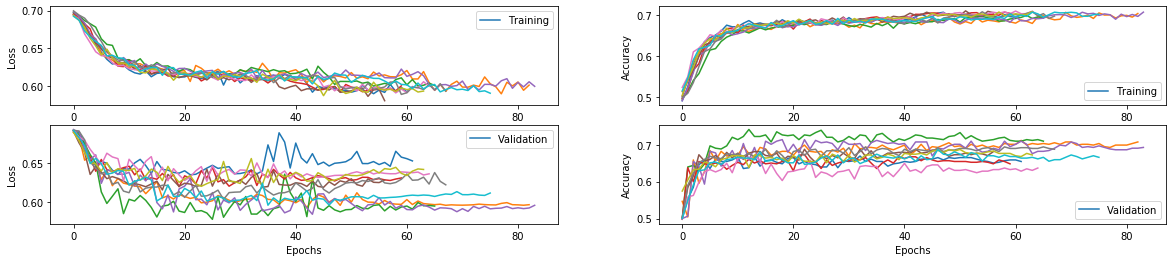

In [56]:
plot_history(cross_histories2, 'model2_cross.pdf')

In [55]:
hhh2= [ h.history for h in cross_histories2 ]
pickle.dump( hhh2, open( "cv_histories_2.p", "wb" ) )

# Final model

In [8]:
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=60, verbose=1)
redlrplat = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=30, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model_final.hdf5', save_best_only=True, verbose=1)

# my_classifier = KerasClassifier(create_model,
#                                 in_dim = x_train.shape[1],
#                                 batch_size=16, 
#                                 epochs=300, 
#                                 verbose=1,
#                                 shuffle=True,
#                                 validation_data=(x_test, y_test), 
#                                 callbacks=[early_stopping, redlrplat, checkpointer])

# fitted_history = my_classifier.fit(x_train, y_train)

model = create_model(in_dim = x_train.shape[1])
# Train and evaluate model:
network_history=model.fit(x_train, y_train, 
            batch_size=16, 
            epochs=300, 
            verbose=1,
            shuffle=True,
            validation_data=(x_test, y_test), 
            callbacks=[early_stopping, redlrplat, checkpointer])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4713 samples, validate on 524 samples
Epoch 1/300
4544/4713 [===========================>..] - ETA: 0s - loss: 0.8081 - acc: 0.5013
Epoch 00001: val_loss improved from inf to 0.70400, saving model to model_final.hdf5
4713/4713 [==============================] - 3s 629us/sample - loss: 0.8052 - acc: 0.5007 - val_loss: 0.7040 - val_acc: 0.4924
Epoch 2/300
4624/4713 [============================>.] - ETA: 0s - loss: 0.7204 - acc: 0.5136
Epoch 00002: val_loss improved from 0.70400 to 0.69896, saving model to model_final.hdf5
4713/4713 [==============================] - 3s 557us/sample - loss: 0.7203 - acc: 0.5124 - val_loss: 0.6990 - val_acc: 0.5076
Epoch 3/300
4672/4713 [============================>.] - ETA: 0s - loss: 0.7066 - acc: 0.5178
Epoch 00003: val_loss improved from 0.69896 to 0.68964, saving model

Epoch 57/300
4640/4713 [============================>.] - ETA: 0s - loss: 0.5973 - acc: 0.6994
Epoch 00057: val_loss did not improve from 0.61580
4713/4713 [==============================] - 2s 395us/sample - loss: 0.5992 - acc: 0.6976 - val_loss: 0.6433 - val_acc: 0.6450
Epoch 58/300
4560/4713 [============================>.] - ETA: 0s - loss: 0.6005 - acc: 0.6906
Epoch 00058: val_loss did not improve from 0.61580
4713/4713 [==============================] - 2s 339us/sample - loss: 0.6012 - acc: 0.6904 - val_loss: 0.6198 - val_acc: 0.6756
Epoch 59/300
4688/4713 [============================>.] - ETA: 0s - loss: 0.5986 - acc: 0.6926
Epoch 00059: val_loss did not improve from 0.61580
4713/4713 [==============================] - 2s 357us/sample - loss: 0.5995 - acc: 0.6921 - val_loss: 0.6159 - val_acc: 0.6660
Epoch 60/300
4544/4713 [===========================>..] - ETA: 0s - loss: 0.6048 - acc: 0.6882
Epoch 00060: val_loss did not improve from 0.61580
4713/4713 [========================

Epoch 87/300
4704/4713 [============================>.] - ETA: 0s - loss: 0.5944 - acc: 0.6956
Epoch 00087: val_loss did not improve from 0.61478
4713/4713 [==============================] - 2s 345us/sample - loss: 0.5941 - acc: 0.6959 - val_loss: 0.6330 - val_acc: 0.6718
Epoch 88/300
4688/4713 [============================>.] - ETA: 0s - loss: 0.5960 - acc: 0.6958
Epoch 00088: val_loss did not improve from 0.61478
4713/4713 [==============================] - 2s 381us/sample - loss: 0.5954 - acc: 0.6959 - val_loss: 0.6247 - val_acc: 0.6775
Epoch 89/300
4608/4713 [============================>.] - ETA: 0s - loss: 0.5932 - acc: 0.6973
Epoch 00089: val_loss did not improve from 0.61478
4713/4713 [==============================] - 2s 503us/sample - loss: 0.5936 - acc: 0.6972 - val_loss: 0.6223 - val_acc: 0.6622
Epoch 90/300
4608/4713 [============================>.] - ETA: 0s - loss: 0.5916 - acc: 0.6990
Epoch 00090: val_loss did not improve from 0.61478
4713/4713 [========================

Epoch 117/300
4624/4713 [============================>.] - ETA: 0s - loss: 0.5887 - acc: 0.6992
Epoch 00117: val_loss did not improve from 0.61412
4713/4713 [==============================] - 2s 401us/sample - loss: 0.5886 - acc: 0.6996 - val_loss: 0.6260 - val_acc: 0.6775
Epoch 118/300
4592/4713 [============================>.] - ETA: 0s - loss: 0.5934 - acc: 0.6995
Epoch 00118: val_loss did not improve from 0.61412
4713/4713 [==============================] - 2s 360us/sample - loss: 0.5923 - acc: 0.7000 - val_loss: 0.6157 - val_acc: 0.6794
Epoch 119/300
4672/4713 [============================>.] - ETA: 0s - loss: 0.5941 - acc: 0.6939
Epoch 00119: val_loss improved from 0.61412 to 0.61247, saving model to model_final.hdf5
4713/4713 [==============================] - 2s 392us/sample - loss: 0.5947 - acc: 0.6930 - val_loss: 0.6125 - val_acc: 0.6813
Epoch 120/300
4624/4713 [============================>.] - ETA: 0s - loss: 0.5927 - acc: 0.6966
Epoch 00120: val_loss did not improve from 0

Epoch 147/300
4576/4713 [============================>.] - ETA: 0s - loss: 0.5950 - acc: 0.6923
Epoch 00147: val_loss did not improve from 0.61247
4713/4713 [==============================] - 2s 341us/sample - loss: 0.5944 - acc: 0.6936 - val_loss: 0.6197 - val_acc: 0.6679
Epoch 148/300
4672/4713 [============================>.] - ETA: 0s - loss: 0.5939 - acc: 0.6943
Epoch 00148: val_loss did not improve from 0.61247
4713/4713 [==============================] - 2s 350us/sample - loss: 0.5938 - acc: 0.6949 - val_loss: 0.6227 - val_acc: 0.6565
Epoch 149/300
4688/4713 [============================>.] - ETA: 0s - loss: 0.5902 - acc: 0.6909
Epoch 00149: val_loss did not improve from 0.61247
4713/4713 [==============================] - 2s 348us/sample - loss: 0.5900 - acc: 0.6911 - val_loss: 0.6304 - val_acc: 0.6679
Epoch 150/300
4688/4713 [============================>.] - ETA: 0s - loss: 0.5946 - acc: 0.6980
Epoch 00150: val_loss did not improve from 0.61247
4713/4713 [====================

Epoch 177/300
4704/4713 [============================>.] - ETA: 0s - loss: 0.5868 - acc: 0.7009
Epoch 00177: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 355us/sample - loss: 0.5870 - acc: 0.7008 - val_loss: 0.6206 - val_acc: 0.6832
Epoch 178/300
4688/4713 [============================>.] - ETA: 0s - loss: 0.5870 - acc: 0.6962
Epoch 00178: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 351us/sample - loss: 0.5868 - acc: 0.6966 - val_loss: 0.6220 - val_acc: 0.6737
Epoch 179/300
4592/4713 [============================>.] - ETA: 0s - loss: 0.5842 - acc: 0.6975
Epoch 00179: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 343us/sample - loss: 0.5856 - acc: 0.6953 - val_loss: 0.6228 - val_acc: 0.6775
Epoch 180/300
4688/4713 [============================>.] - ETA: 0s - loss: 0.5877 - acc: 0.6982
Epoch 00180: val_loss did not improve from 0.61233
4713/4713 [====================

Epoch 207/300
4624/4713 [============================>.] - ETA: 0s - loss: 0.5854 - acc: 0.7013
Epoch 00207: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 346us/sample - loss: 0.5842 - acc: 0.7021 - val_loss: 0.6220 - val_acc: 0.6794
Epoch 208/300
4704/4713 [============================>.] - ETA: 0s - loss: 0.5848 - acc: 0.6998
Epoch 00208: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 350us/sample - loss: 0.5847 - acc: 0.6996 - val_loss: 0.6210 - val_acc: 0.6832
Epoch 209/300
4624/4713 [============================>.] - ETA: 0s - loss: 0.5805 - acc: 0.7022
Epoch 00209: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 374us/sample - loss: 0.5801 - acc: 0.7023 - val_loss: 0.6218 - val_acc: 0.6832
Epoch 210/300
4592/4713 [============================>.] - ETA: 0s - loss: 0.5805 - acc: 0.7041
Epoch 00210: val_loss did not improve from 0.61233
4713/4713 [====================

Epoch 237/300
4576/4713 [============================>.] - ETA: 0s - loss: 0.5822 - acc: 0.6989
Epoch 00237: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 370us/sample - loss: 0.5822 - acc: 0.6991 - val_loss: 0.6201 - val_acc: 0.6851
Epoch 238/300
4576/4713 [============================>.] - ETA: 0s - loss: 0.5830 - acc: 0.6995
Epoch 00238: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 392us/sample - loss: 0.5836 - acc: 0.6989 - val_loss: 0.6195 - val_acc: 0.6851
Epoch 239/300
4608/4713 [============================>.] - ETA: 0s - loss: 0.5875 - acc: 0.6955
Epoch 00239: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 391us/sample - loss: 0.5865 - acc: 0.6951 - val_loss: 0.6209 - val_acc: 0.6737
Epoch 240/300
4656/4713 [============================>.] - ETA: 0s - loss: 0.5826 - acc: 0.6957
Epoch 00240: val_loss did not improve from 0.61233
4713/4713 [====================

Epoch 267/300
4688/4713 [============================>.] - ETA: 0s - loss: 0.5804 - acc: 0.6971
Epoch 00267: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 358us/sample - loss: 0.5798 - acc: 0.6976 - val_loss: 0.6219 - val_acc: 0.6832
Epoch 268/300
4560/4713 [============================>.] - ETA: 0s - loss: 0.5828 - acc: 0.6967
Epoch 00268: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 330us/sample - loss: 0.5823 - acc: 0.6957 - val_loss: 0.6220 - val_acc: 0.6794
Epoch 269/300
4560/4713 [============================>.] - ETA: 0s - loss: 0.5787 - acc: 0.6943
Epoch 00269: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 332us/sample - loss: 0.5776 - acc: 0.6953 - val_loss: 0.6225 - val_acc: 0.6794
Epoch 270/300
4560/4713 [============================>.] - ETA: 0s - loss: 0.5840 - acc: 0.6985
Epoch 00270: val_loss did not improve from 0.61233
4713/4713 [====================

Epoch 297/300
4704/4713 [============================>.] - ETA: 0s - loss: 0.5801 - acc: 0.6998
Epoch 00297: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 452us/sample - loss: 0.5801 - acc: 0.7000 - val_loss: 0.6223 - val_acc: 0.6813
Epoch 298/300
4640/4713 [============================>.] - ETA: 0s - loss: 0.5812 - acc: 0.6968
Epoch 00298: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 446us/sample - loss: 0.5818 - acc: 0.6966 - val_loss: 0.6224 - val_acc: 0.6813
Epoch 299/300
4656/4713 [============================>.] - ETA: 0s - loss: 0.5847 - acc: 0.6976
Epoch 00299: val_loss did not improve from 0.61233
4713/4713 [==============================] - 2s 383us/sample - loss: 0.5842 - acc: 0.6976 - val_loss: 0.6222 - val_acc: 0.6813
Epoch 300/300
4672/4713 [============================>.] - ETA: 0s - loss: 0.5827 - acc: 0.6971
Epoch 00300: val_loss did not improve from 0.61233
4713/4713 [====================

In [22]:
# my_classifier.model.save("model_final2.hdf5")
model.save("model_final2.hdf5")

In [9]:
def plot_history_onemodel(network_history, fp=None):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Test'])

    plt.subplot(1,2,2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Test'], loc='lower right')
    
    plt.savefig(fp, bbox_inches='tight')
    plt.show()

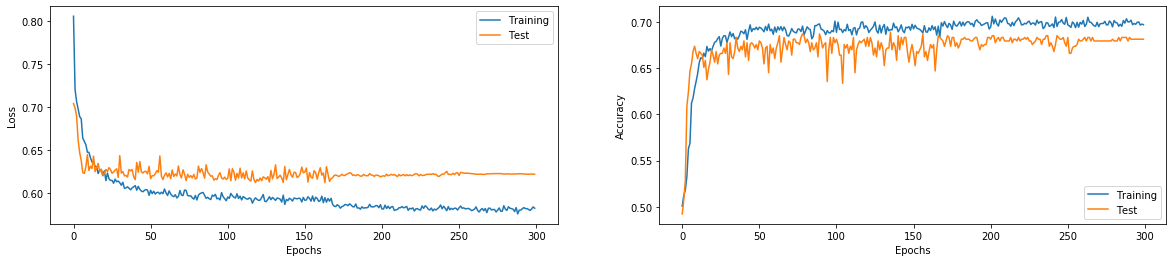

In [10]:
plot_history_onemodel(fitted_history, "final_model.pdf")

## XGBoost
for comparison with the NN model

In [12]:
gbtree = xgboost.XGBClassifier(objective='binary:logistic', eta=0.01,
                               max_depth=3, colsample_bytree=0.75, n_estimators=500)
gbtree.fit(x_train, y_train)

print(accuracy_score(y_train, gbtree.predict(x_train)))
print(accuracy_score(y_test, gbtree.predict(x_test)))

0.818586887332909
0.6564885496183206


## RandomForest
for comparison with the NN model

In [13]:
rfmod = RandomForestClassifier(n_estimators=500, max_depth= 5)
rfmod.fit(x_train, y_train)

print(rfmod.score(x_train,y_train))
print(rfmod.score(x_test, y_test))

0.7105877360492255
0.6583969465648855


# Bagging estimator

In [19]:
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_sklearn_model():
#     dens = np.random.choice([16,24,32,40])
#     dep = np.random.choice([3,4,5,6,7])
#     act = np.random.choice(['selu', 'relu', 'sigmoid'])
#     drop =np.random.choice([.2,.3,.4,.5])
    
    my_classifier = KerasClassifier(create_model,
                                    in_dim=x_train.shape[1],
                                    dense_layer_sizes = 24,
                                    dropout_ratios = .4,
                                    depth = 7,
                                    activ= 'selu',
                                batch_size=16, 
                                epochs=50, 
                                verbose=0,
                                shuffle=True)
    return my_classifier


bagclf = BaggingClassifier(base_estimator=create_sklearn_model(),
                           n_estimators=10,
                           random_state=0,
                          bootstrap=True)

bagclf.fit(x_train, y_train)

BaggingClassifier(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f27e689e668>,
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
bagclf.score(x_test, y_test)

0.6469465648854962

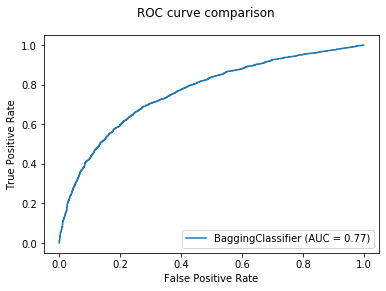

In [21]:
from sklearn.metrics import plot_roc_curve

bagclf_disp = plot_roc_curve(bagclf, x_train, y_train)
bagclf_disp.figure_.suptitle("ROC curve comparison")

plt.show()

### reload the NN model:

In [22]:
finmod = tf.keras.models.load_model("model_final2.hdf5")

In [23]:
finmod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                1128      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                6

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def roccc(model, modelname, tfkeras = False):
    if tfkeras:
        y_hat = model.predict(x_test)
    else:
        y_hat = model.predict_proba(x_test)[:,1]
        

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr[0], tpr[0], _ = roc_curve(y_test, y_hat)
    roc_auc[0] = auc(fpr[0], tpr[0])

#     # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_hat.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 1
    ROC = plt.plot(fpr[0], tpr[0],
         lw=lw, label = modelname + ' ROC (area = %0.2f)' % roc_auc[0])
    
    return fpr, tpr, roc_auc

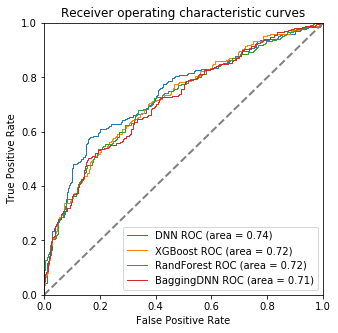

In [25]:
plt.figure(figsize=(5,5))

roccc(finmod, tfkeras=True, modelname = 'DNN')
roccc(gbtree, modelname = 'XGBoost')
roccc(rfmod, modelname = 'RandForest')
roccc(bagclf, modelname = 'BaggingDNN')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc="lower right")

plt.savefig('roc_compa.pdf', bbox_inches='tight')
plt.show()